# Import

In [1]:
from google.colab import drive

import torch
import torch.nn as nn

from google.colab import drive

import json
import cv2
import glob
import os
import time
import copy

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as utils
import torchvision.datasets as datasets


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import pandas as pd

from skimage import io, transform

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,classification_report

from torch.optim.lr_scheduler import StepLR ,ReduceLROnPlateau
from tqdm import tqdm




In [2]:
import numpy as np

import random
import matplotlib.patches as patches

import torchvision
from torchvision import ops
from torch.nn.utils.rnn import pad_sequence

In [3]:
drive.mount('/content/drive', force_remount=True)

ValueError: mount failed

# Config and init

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# utils

In [ ]:
def display_img_(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean
            img = np.clip(img, 0, 1)

        axes[i].imshow(img)

    return fig, axes

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    '''
    finds the offset of anchor coords and bbox coords
    '''
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

def gen_anc_centers(out_size):
    '''
    gets (out_h, out_w) as input returns the centers of anchors of the image
    '''
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y


def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):

    '''
    this function transforms the bboxes from activation map to pixel image.
    bboxes input is a batch of bboxes (2 if batchsize is 2)
    width_scale and height_scale factors are the (image/feature_map)
    '''
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

def generate_proposals(anchors, offsets):
    '''
    applies offsets to anchors to create proposals
    '''
    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    '''
    generates anchor boxes
    '''
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    '''
    since we have the same anc boxes for all images we only pass one single anc boxes of shape [-1,4]
    '''
    # get total anchor boxes for a single image

    tot_anc_boxes = anc_boxes_all.shape[0]

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.shape[1]))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        # anc_boxes = anc_boxes_flat[i]
        anc_boxes = anc_boxes_all

        # ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)


    return ious_mat

# # -------------- Visualization utils ----------------
def tensorimshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def display_img(img_data, fig, axes):
    inp = img_data.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axes.imshow(inp)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)

    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category

        name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
        idx2name = {v:k for k, v in name2idx.items()}

        if not classes == None:
            if idx2name[classes[c].item()] == 'pad':
                continue
            ax.text(x + 5, y + 20, idx2name[classes[c].item()] , bbox=dict(facecolor='yellow', alpha=0.5))

        c += 1

    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

In [ ]:
def create_data_pairs(input_path, dir_type = 'train'):

    img_paths = Path(input_path +f'/{dir_type}/images/').glob('*.jpg')

    pairs = []
    for img_path in img_paths:

        file_name_tmp = str(img_path).split('/')[-1].split('.')
        file_name_tmp.pop(-1)
        file_name = '.'.join((file_name_tmp))

        label_path = Path(input_path + f'/{dir_type}/labels/' + file_name + '.txt')

        if label_path.is_file():

            line_img = input_path + f'/{dir_type}/images/'+ file_name + '.jpg'
            line_annot = input_path+f'/{dir_type}/labels/' + file_name + '.txt'
            pairs.append([line_img, line_annot])

    return pairs


In [ ]:
def create_data_format(data_pairs, img_w=256, img_h=256):
    # to fix the problems of later labeling final image sizes are included in the inputs of the function

    data_list = []

    for i, path in enumerate(data_pairs):

        filename = path[0]

        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w

        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')

                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])

                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h

                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "category_id": int(class_id),
                }

                annotations.append(annotation)


            img_item["annotations"] = annotations
        if not len(annotations):
              continue

        data_list.append(img_item)
    return data_list


# Data

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drivea/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d slavkoprytula/aquarium-data-cots
!unzip './aquarium-data-cots.zip'

## Augmentation (includes Mosaic Augmentation)

### mosaic augmentation

In [73]:
main_dir = '/content/aquarium_pretrain'
train_dir = f'{main_dir}/train'
valid_dir = f'{main_dir}/valid'
test_dir = f'{main_dir}/test'

all_images = []
all_labels = []
for dir in [train_dir, valid_dir, test_dir]:
  images_dir = f'{dir}/images'
  labels_dir = f'{dir}/labels'

  images = []
  labels = []

  for filename in os.listdir(images_dir):
    if filename.endswith('.jpg'):

      file_path = os.path.join(images_dir, filename)
      img = cv2.imread(file_path)
      img = cv2.resize(img,(1024,1024))

      images.append(np.array(img))

      name = filename[:-4]
      new_filename = f'{name}.txt'

      file_path = os.path.join(labels_dir, new_filename)

      current_labels = []
      with open(file_path, 'r') as file:
        for line in file:
          numbers = line.split()
          current_labels.append(numbers)
        labels.append(current_labels)

  all_images.append(images)
  all_labels.append(labels)

In [74]:
X_train = all_images[0]
X_valid = all_images[1]
X_test = all_images[2]

y_train = all_labels[0]
y_valid = all_labels[1]
y_test = all_labels[2]

In [79]:
def mosaic_augmentation(images, labels):
  assert len(images) == 4, "there should exactly be 4 images for mosaic augmentation"
  for image in images:
    assert len(image) == len(image[0]), "images should be square shaped"
  h = len(image)
  mosaic = np.zeros((h * 2, h * 2, 3), dtype=np.uint8)

  mosaic[:h, :h] = images[0]
  mosaic[:h, h:] = images[1]
  mosaic[h:, :h] = images[2]
  mosaic[h:, h:] = images[3]

  new_labels = []
  for label in labels[0]:
    new_label = [int(label[0]), float(label[1])/2, float(label[2])/2, float(label[3])/2, float(label[4])/2]
    new_labels.append(new_label)

  for label in labels[1]:
    new_label = [int(label[0]), 0.5 + float(label[1])/2, float(label[2])/2, float(label[3])/2, float(label[4])/2 ]
    new_labels.append(new_label)

  for label in labels[2]:
    new_label = [int(label[0]), float(label[1])/2, 0.5 + float(label[2])/2, float(label[3])/2, float(label[4])/2 ]
    new_labels.append(new_label)

  for label in labels[3]:
    new_label = [int(label[0]), 0.5 + float(label[1])/2, float(label[2])/2 + 0.5, float(label[3])/2, float(label[4])/2 ]
    new_labels.append(new_label)

  return mosaic, new_labels

In [92]:
mos, labs = mosaic_augmentation(X_train[0:4], y_train[0:4])

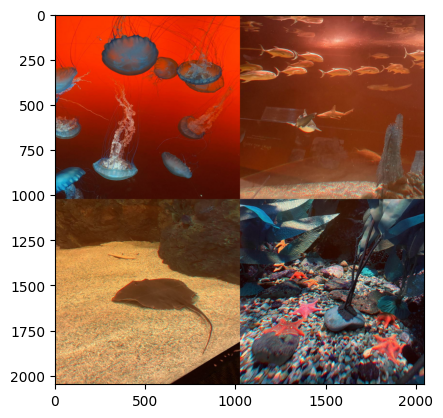

In [93]:
plt.imshow(mos)

In [87]:
def plot_bboxes(image, labels):
  h = len(image)
  for bound in labels:
    x_center = int(float(bound[1])*h)
    y_center = int(float(bound[2])*h)
    width = int(float(bound[3])*h)
    height = int(float(bound[4])*h)
    new = cv2.rectangle(image, (x_center-int(width/2), y_center-int(height/2)), (x_center+int(width/2), y_center+int(height/2)), (0,255,0),3)
  return new

In [90]:
nomos = plot_bboxes(mos, labs)

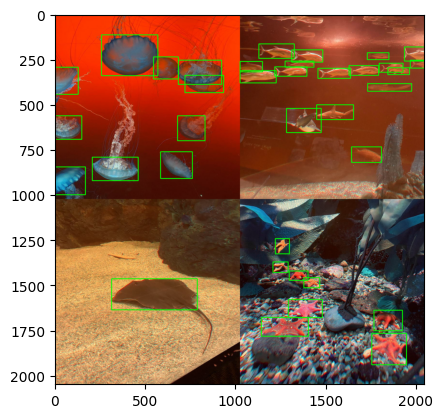

In [89]:
plt.imshow(nomos)

### flip and contrast augmentation

In [133]:
def augmentation(image, labels, horizontal_invert=True, contrast=True):
    h = len(image)
    aug_image = image.copy()
    aug_labels = []

    if horizontal_invert == True:
        aug_image = cv2.flip(aug_image, 1)
        for label in labels:
            new_label = [int(label[0]), 1-float(label[1]), float(label[2]), float(label[3]), float(label[4])]
            aug_labels.append(new_label)

    if horizontal_invert == False:
        aug_labels = labels.copy()

    if contrast == True:
        image_float = aug_image.astype(np.float32)


        b, g, r = cv2.split(image_float)


        contrast_factor = 1.5
        r_contrast = np.clip(r * contrast_factor, 0, 255)
        g_contrast = np.clip(g * contrast_factor, 0, 255)
        b_contrast = np.clip(b * contrast_factor, 0, 255)

        adjusted_image = cv2.merge((b_contrast, g_contrast, r_contrast))

        aug_image = adjusted_image.astype(np.uint8)



    return aug_image, aug_labels


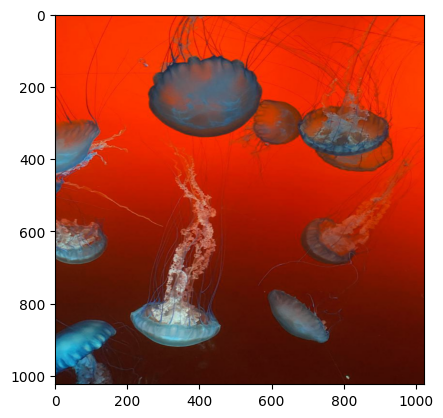

In [134]:
plt.imshow(X_train[0])

In [135]:
i, l = augmentation(X_train[0], y_train[0])

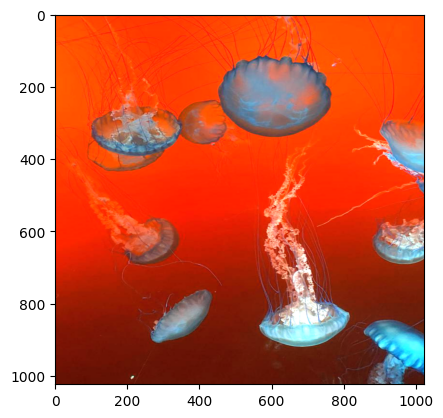

In [136]:
plt.imshow(i)

In [137]:
no = plot_bboxes(i, l)

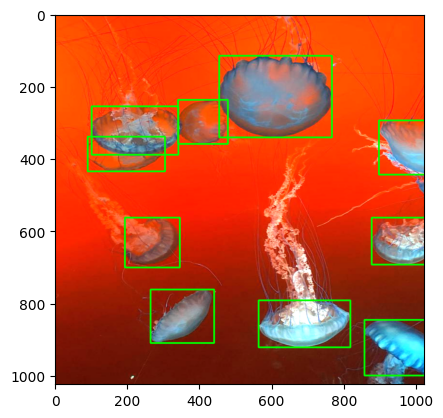

In [138]:
plt.imshow(no)

## Dataloader

In [69]:
from pathlib import Path

In [70]:
input_path = './aquarium_pretrain'
train = create_data_pairs(input_path, 'train')
val = create_data_pairs(input_path, 'valid')
test = create_data_pairs(input_path, 'test')

In [71]:
train_list = create_data_format(train)
val_list = create_data_format(val)
test_list = create_data_format(test)

In [72]:
class ObjectDetectionDataset(Dataset):

    def __init__(self, data, img_size, name2idx,transform):

        self.data = data
        self.img_size = img_size
        self.name2idx = name2idx
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        info = self.data[idx]
        '''
        based on previous functions info contains:
        'file_name': path to the image
        'image_id': equal to idx
        'height':
        'width':
        'annotations': bboxes
        '''

        path = info['file_name']
        img = Image.open(path).convert("RGB")

        annotations = info['annotations']
        bboxes = []
        labels = []

        for bound in annotations:
            '''
            bound contains:
            'bbox' and 'category_id'(label)
            '''
            bboxes.append(bound['bbox'])
            labels.append(bound['category_id'])

        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if self.transform is not None:
            img = self.transform(img)

        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels

        return img, target


In [17]:
img_width = 256
img_height = 256

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

}
## the following mapping is available on the data source
name2idx = {
    'pad': -1,
    'fish': 0,
    'jellyfish': 1,
    'penguin': 2,
    'puffin': 3,
    'shark': 4,
    'starfish': 5,
    'stingray': 6
}

idx2name = {v: k for k, v in name2idx.items()}


In [18]:
od_dataset = ObjectDetectionDataset(train_list, (img_height, img_width), name2idx, data_transforms['train'])
od_dataset_val = ObjectDetectionDataset(val_list, (img_height, img_width), name2idx, data_transforms['test'])
od_dataset_test = ObjectDetectionDataset(test_list, (img_height, img_width), name2idx, data_transforms['test'])

In [19]:
def collate_fn(batch):
    images = []
    bboxes = []
    labels = []
    targets = []
    # Find the maximum number of bounding boxes in a batch
    max_num_boxes = max(len(item['boxes']) for _, item in batch)

    for img, target in batch:
        images.append(img)

        # Pad bounding boxes with -1
        padded_boxes = torch.cat([
            target['boxes'],
            torch.full((max_num_boxes - len(target['boxes']), 4), -1, dtype=torch.float32)
        ], dim=0)
        bboxes.append(padded_boxes)

        # Pad labels with -1
        padded_labels = torch.cat([
            target['labels'],
            torch.full((max_num_boxes - len(target['labels']),), -1, dtype=torch.int64)
        ], dim=0)
        labels.append(padded_labels)

        target = {'boxes': padded_boxes, 'labels': padded_labels}
        targets.append(target)



    images = torch.stack(images, dim=0)
    bboxes = torch.stack(bboxes, dim=0)
    labels = torch.stack(labels, dim=0)

    # targets : {'boxes': bboxes, 'labels': labels}

    return images, targets

In [20]:
od_dataloader = DataLoader(od_dataset, batch_size=4 ,  collate_fn = collate_fn , drop_last=True)
od_dataloader_val = DataLoader(od_dataset_val, batch_size=4 ,  collate_fn = collate_fn , drop_last=True)
od_dataloader_test = DataLoader(od_dataset_test, batch_size=4 ,  collate_fn = collate_fn , drop_last=True)

## EDA

total images count in the training set:444


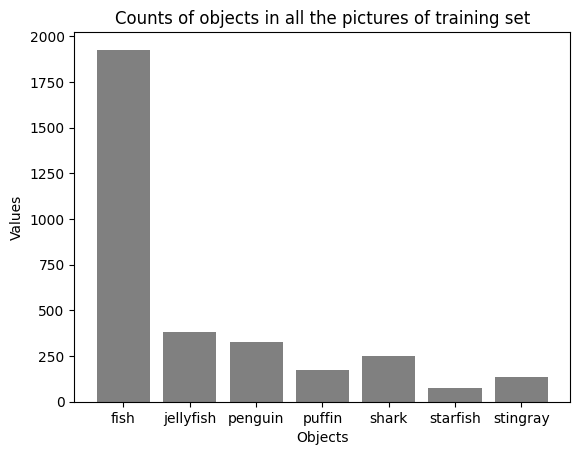

In [145]:
images_count = 0
labels_count = {}
dl = od_dataloader
for img_batch, targets in dl:
    for i in range(dl.batch_size):
        images_count += 1
        labels = targets[i]['labels']
        for label in labels:
            label = int(label)
            if label in labels_count.keys():
                labels_count[int(label)] = labels_count[int(label)] + 1
            else:
                labels_count[int(label)] = 0

labels_count = {key: labels_count[key] for key in sorted(labels_count)}
labels_count.pop(-1)

print(f'total images count in the training set:{images_count}')

counts = list(labels_count.values())
labels = list(name2idx.keys())[1:]

plt.bar(labels, counts, color='grey')

plt.xlabel('Objects')
plt.ylabel('Values')
plt.title('Counts of objects in all the pictures of training set')


plt.show()



total images count in the validation set:124


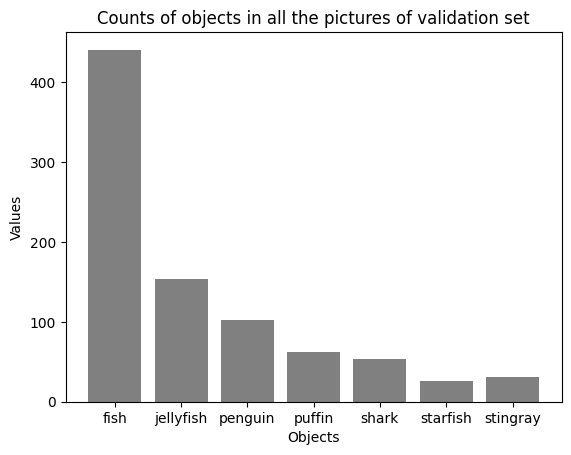

In [146]:
images_count = 0
labels_count = {}
dl = od_dataloader_val
for img_batch, targets in dl:
    for i in range(dl.batch_size):
        images_count += 1
        labels = targets[i]['labels']
        for label in labels:
            label = int(label)
            if label in labels_count.keys():
                labels_count[int(label)] = labels_count[int(label)] + 1
            else:
                labels_count[int(label)] = 0

labels_count = {key: labels_count[key] for key in sorted(labels_count)}
labels_count.pop(-1)

print(f'total images count in the validation set:{images_count}')

counts = list(labels_count.values())
labels = list(name2idx.keys())[1:]

plt.bar(labels, counts, color='grey')

plt.xlabel('Objects')
plt.ylabel('Values')
plt.title('Counts of objects in all the pictures of validation set')


plt.show()



total images count in the test set:60


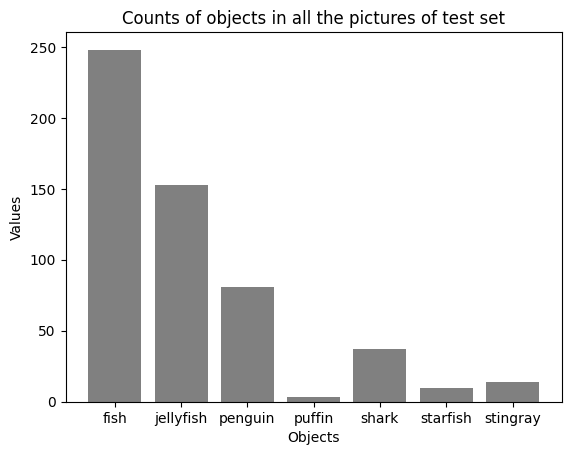

In [147]:
images_count = 0
labels_count = {}
dl = od_dataloader_test
for img_batch, targets in dl:
    for i in range(dl.batch_size):
        images_count += 1
        labels = targets[i]['labels']
        for label in labels:
            label = int(label)
            if label in labels_count.keys():
                labels_count[int(label)] = labels_count[int(label)] + 1
            else:
                labels_count[int(label)] = 0

labels_count = {key: labels_count[key] for key in sorted(labels_count)}
labels_count.pop(-1)

print(f'total images count in the test set:{images_count}')

counts = list(labels_count.values())
labels = list(name2idx.keys())[1:]

plt.bar(labels, counts, color='grey')

plt.xlabel('Objects')
plt.ylabel('Values')
plt.title('Counts of objects in all the pictures of test set')


plt.show()



In [21]:
for img_batch, targets in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = [t['boxes'] for t in targets]
    gt_classes_all = [t['labels'] for t in targets]
    break

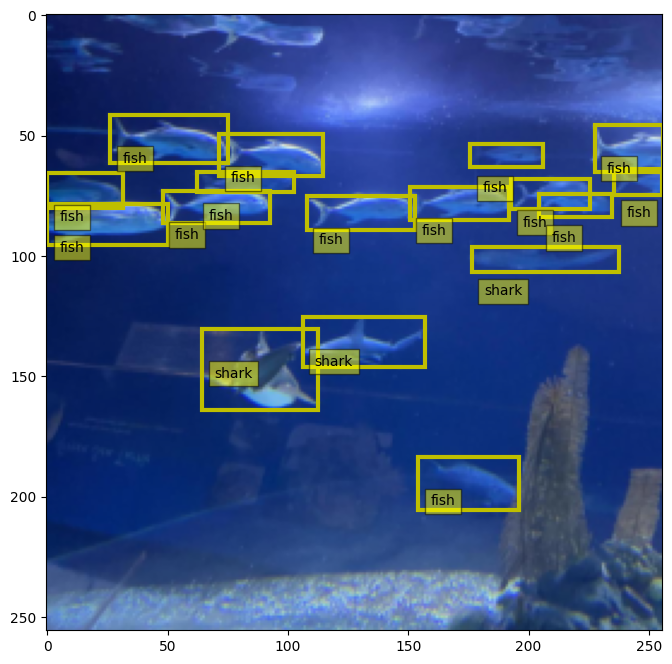

In [ ]:
nrows, ncols = (1, 1)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch[1], fig, axes)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes, classes=gt_classes_all[1])


# Model

## Backbone model

In [ ]:
from torchvision.models import resnet101

def get_backbone_model(pretrained = True, requires_grad=False):
    backbone = torchvision.models.resnet50(pretrained=pretrained)

    #we need to remove the fully connected layer
    modules = list(backbone.children())[:-2]
    backbone = nn.Sequential(*modules)
    for param in backbone.named_parameters():
        param[1].requires_grad = requires_grad

    return backbone


In [ ]:
backbone = get_backbone_model().to(device)

for img_batch, targets in od_dataloader:
    img_batch = img_batch.to(device)
    break

with torch.no_grad():
    out = backbone(img_batch)


## for later use
gt_bboxes_all = [t['boxes'] for t in targets]
gt_classes_all = [t['labels'] for t in targets]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [ ]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
width_scale_factor = img_width / out_w
height_scale_factor = img_height / out_h

In [ ]:
print(f"Width Down-scaling Factor: {width_scale_factor}")
print(f"Height Down-scaling Factor: {height_scale_factor}")

Width Down-scaling Factor: 32.0
Height Down-scaling Factor: 32.0


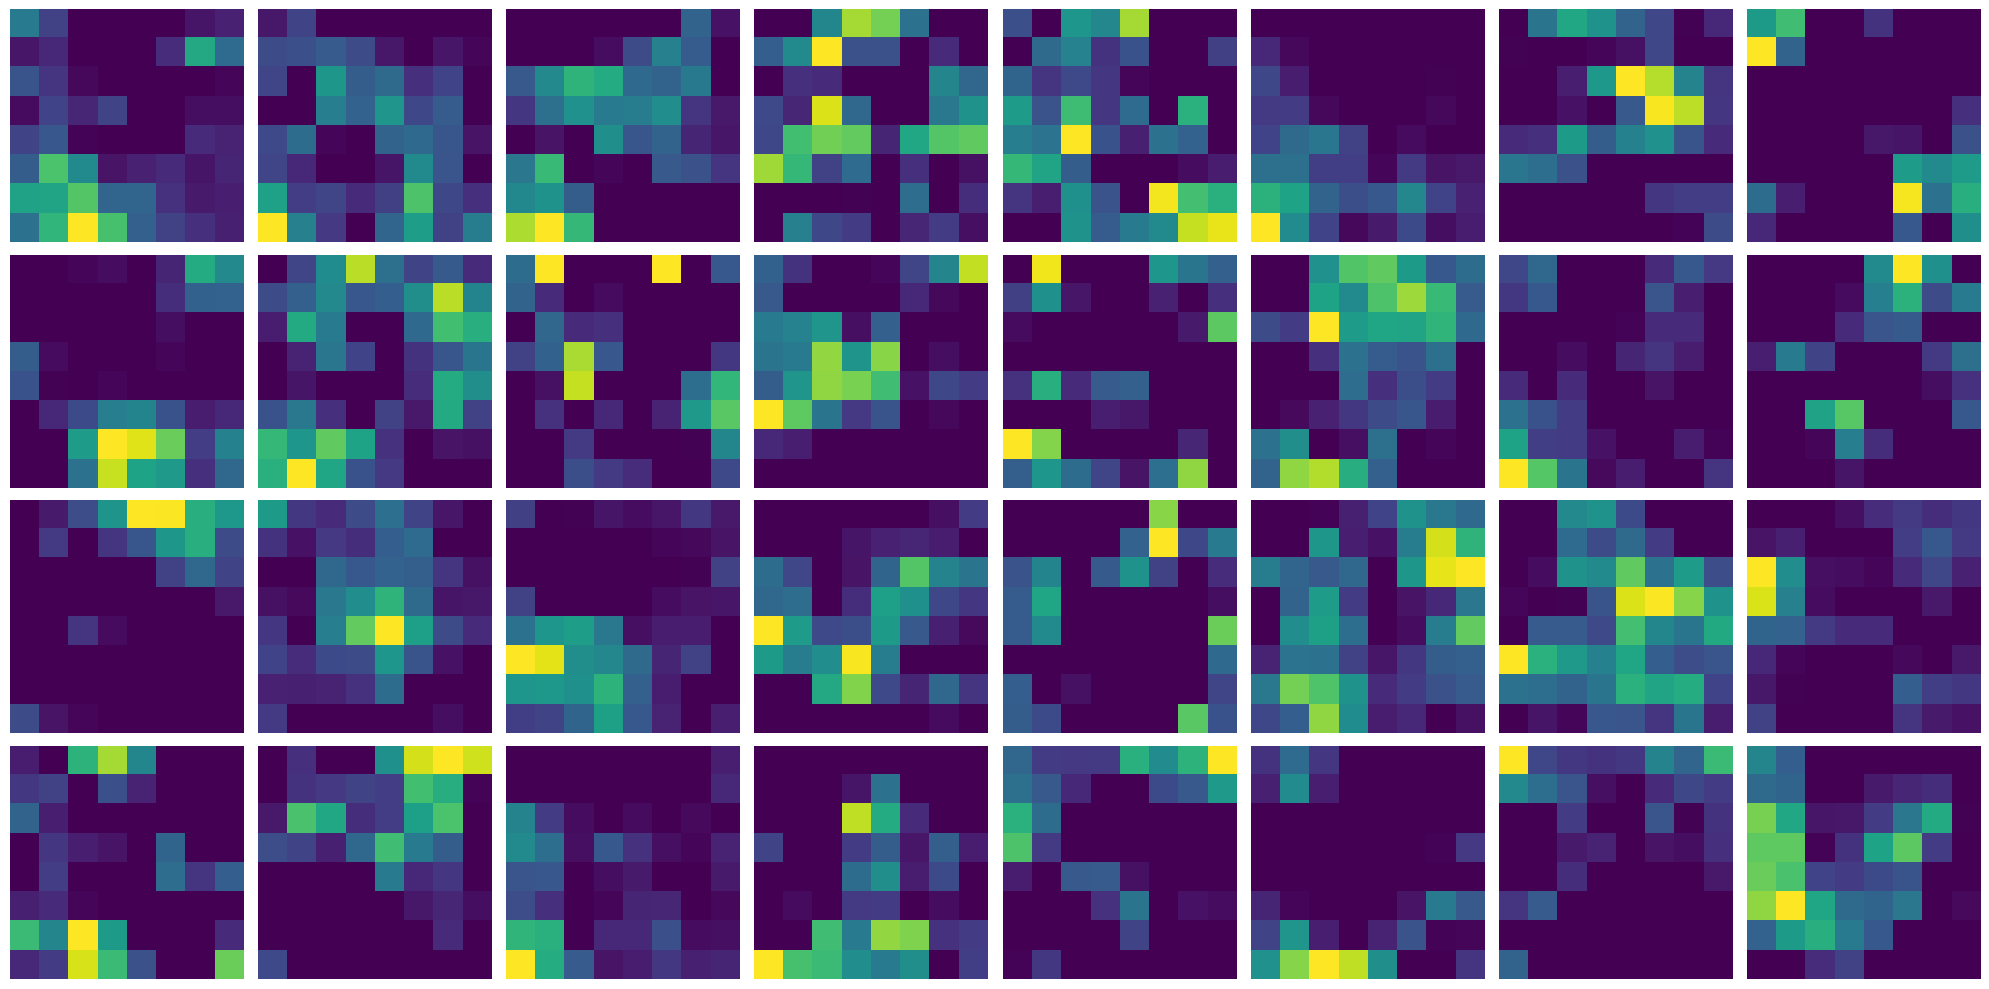

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()

for i in range(32):  # Plotting 32 feature maps
    axes[i].imshow(out[0, i, :, :].cpu(), cmap='viridis')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Generate and Plot Anchor Points

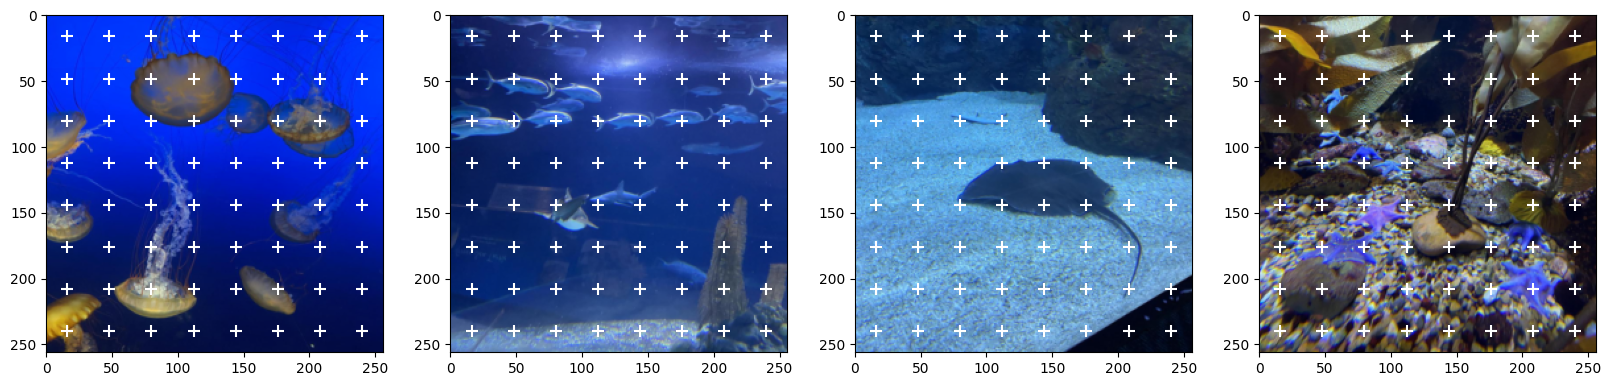

In [ ]:
'''
in this section some functions from util section are used

gen_anc_centers(out_size)

we also need a function to plot the anchor points
'''

def plot_anchor_points(img_batch, anc_pts_x, anc_pts_y, width_scale_factor, height_scale_factor):
    nrows = img_batch.size(0)
    fig, axes = plt.subplots(1, nrows, figsize=(20, 5))
    if nrows == 1:
        axes = [axes]

    for i, img in enumerate(img_batch):
        img = img.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = axes[i]
        ax.imshow(img)

        anc_pts_x_scaled = anc_pts_x * width_scale_factor
        anc_pts_y_scaled = anc_pts_y * height_scale_factor

        for x in anc_pts_x_scaled:
            for y in anc_pts_y_scaled:
                ax.scatter(x, y, color='w', s=80, marker='+')

        ax.set_xlim(0, img.shape[1])
        ax.set_ylim(img.shape[0], 0)

    plt.show()

out_h, out_w = out.size(2), out.size(3)
anc_pts_x, anc_pts_y = gen_anc_centers((out_h, out_w))
example_img_batch = img_batch[:4]  # Plot first 4 images
plot_anchor_points(example_img_batch, anc_pts_x, anc_pts_y, width_scale_factor, height_scale_factor)


## Create Anchor Boxes around Anchor points

In [ ]:
import torch
from torchvision.ops import box_convert



anchor_scales = [32, 64, 96]
anchor_ratios = [0.5, 1.0, 1.5]

def generate_anchor_boxes(anc_pts_x, anc_pts_y, scales, ratios, img_size):
    anchors = []
    img_h, img_w = img_size
    for x in anc_pts_x:
        for y in anc_pts_y:
            for scale in scales:
                for ratio in ratios:
                    w = scale * ratio
                    h = scale
                    xmin = x - w / 2
                    ymin = y - h / 2
                    xmax = x + w / 2
                    ymax = y + h / 2

                    xmin = torch.clamp(xmin, 0, img_w)
                    ymin = torch.clamp(ymin, 0, img_h)
                    xmax = torch.clamp(xmax, 0, img_w)
                    ymax = torch.clamp(ymax, 0, img_h)
                    anchors.append(torch.tensor([xmin, ymin, xmax, ymax]))
    return anchors



img_size = (img_height, img_width)


out_h, out_w = out.size(2), out.size(3)
anc_pts_x, anc_pts_y = gen_anc_centers((out_h, out_w))


anc_pts_x = anc_pts_x * width_scale_factor
anc_pts_y = anc_pts_y * height_scale_factor


anchor_boxes = generate_anchor_boxes(anc_pts_x, anc_pts_y, anchor_scales, anchor_ratios, img_size)

anchor_boxes = torch.stack(anchor_boxes)



torch.Size([576, 4])
torch.Size([576, 4])


In [ ]:
print(anchor_boxes)

tensor([[  8.,   0.,  24.,  32.],
        [  0.,   0.,  32.,  32.],
        [  0.,   0.,  40.,  32.],
        ...,
        [216., 192., 256., 256.],
        [192., 192., 256., 256.],
        [168., 192., 256., 256.]])


## plot anchor boxes on a single anchor point

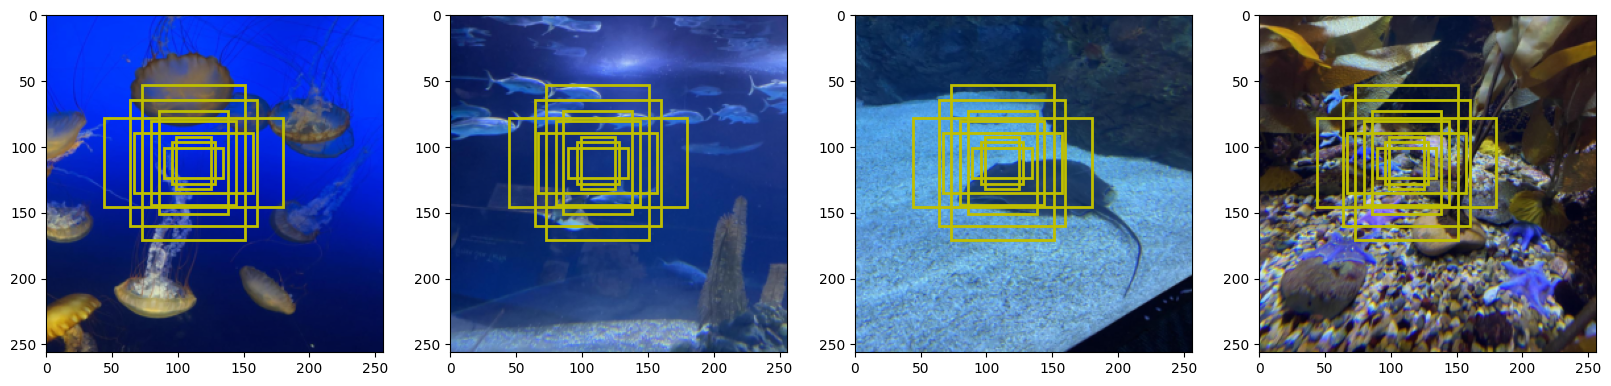

In [ ]:
def generate_anchor_boxes_single_point(x, y, scales, ratios, img_size):
    anchors = []
    img_h, img_w = img_size
    for scale in scales:
        for ratio in ratios:
            area = scale * scale
            w = torch.sqrt(torch.tensor(area / ratio))
            h = ratio * w
            xmin = x - w / 2
            ymin = y - h / 2
            xmax = x + w / 2
            ymax = y + h / 2
            # Clip boxes to image size
            xmin = torch.clamp(xmin, 0, img_w)
            ymin = torch.clamp(ymin, 0, img_h)
            xmax = torch.clamp(xmax, 0, img_w)
            ymax = torch.clamp(ymax, 0, img_h)

            anchors.append(torch.tensor([xmin, ymin, xmax, ymax]))
    return anchors



def plot_anchor_boxes(img_batch, anchor_boxes, anc_pts_x, anc_pts_y, width_scale_factor, height_scale_factor):
    nrows = img_batch.size(0)
    fig, axes = plt.subplots(1, nrows, figsize=(20, 5))
    if nrows == 1:
        axes = [axes]

    for i, img, in enumerate(img_batch):
        img = img.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = axes[i]
        ax.imshow(img)

        anc_pts_x_scaled = anc_pts_x * width_scale_factor
        anc_pts_y_scaled = anc_pts_y * height_scale_factor

        for x in anc_pts_x_scaled:
            for y in anc_pts_y_scaled:
                ax.scatter(x, y, color='w', s=80, marker='+')

        for box in anchor_boxes:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='y', facecolor='none')
            ax.add_patch(rect)

        ax.set_xlim(0, img.shape[1])
        ax.set_ylim(img.shape[0], 0)

    plt.show()



example_img = img_batch[0]

anchor_x, anchor_y = anc_pts_x[3].item() , anc_pts_y[3].item()

anchor_boxes_single_point = generate_anchor_boxes_single_point(anchor_x, anchor_y, anchor_scales, anchor_ratios, img_size)

plot_anchor_boxes(img_batch, anchor_boxes_single_point, anc_pts_x, anc_pts_y, width_scale_factor, height_scale_factor)



## plot all anchor boxes

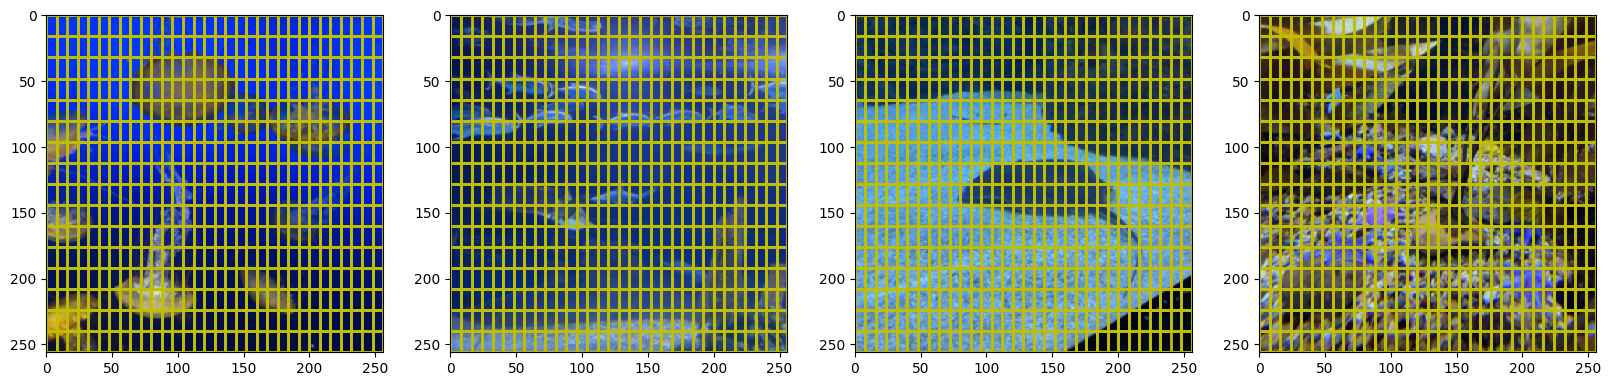

In [ ]:
plot_anchor_boxes(img_batch, anchor_boxes, anc_pts_x, anc_pts_y, width_scale_factor, height_scale_factor)


## Get Positive and Negative Anchors

In [ ]:
def get_req_anchors(anchor_boxes, gt_bboxes_all, gt_classes_all, pos_thresh=0.5, neg_thresh=0.3):

    gt_bboxes_all = torch.stack(gt_bboxes_all)
    gt_classes_all = torch.stack(gt_classes_all)

    batch_size = gt_bboxes_all.shape[0]
    tot_anc_boxes = anchor_boxes.shape[0]
    max_num_gt_boxes = gt_bboxes_all.shape[1]

    # Get the IoU matrix
    iou_mat = get_iou_mat(batch_size, anchor_boxes, gt_bboxes_all)

    positive_anc_indices = []
    negative_anc_indices = []
    positive_anc_coords = []
    negative_anc_coords = []
    gt_conf_scores = []
    gt_offsets = []
    gt_classes = []

    for i in range(batch_size):
        iou_per_image = iou_mat[i]
        gt_bboxes = gt_bboxes_all[i]
        gt_cls = gt_classes_all[i]

        # Determine positive anchors
        max_iou_per_gt_box, _ = iou_per_image.max(dim=0, keepdim=True)
        positive_anc_mask = (iou_per_image == max_iou_per_gt_box) & (max_iou_per_gt_box > 0)
        positive_anc_mask = positive_anc_mask | (iou_per_image > pos_thresh)
        positive_anc_ind_sep = torch.where(positive_anc_mask)[0]

        positive_indices = torch.where(positive_anc_mask.any(dim=1))[0]
        positive_anc_indices.append(positive_indices)

        # Determine negative anchors
        max_iou_per_anc, max_iou_indices = iou_per_image.max(dim=1)
        negative_anc_mask = max_iou_per_anc < neg_thresh
        negative_indices = torch.where(negative_anc_mask)[0]
        negative_anc_indices.append(negative_indices)

        # Gather GT confidence scores for positive anchors
        gt_conf_scores.append(max_iou_per_anc[positive_indices])

        # Gather GT classes for positive anchors
        gt_class_per_anc = gt_cls[max_iou_indices]
        gt_classes.append(gt_class_per_anc[positive_indices])

        # Gather GT offsets for positive anchors
        gt_bboxes_pos = gt_bboxes[max_iou_indices[positive_indices]]
        pos_anc_coords = anchor_boxes[positive_indices]
        positive_anc_coords.append(pos_anc_coords)
        neg_anc_coords = anchor_boxes[negative_indices]
        negative_anc_coords.append(neg_anc_coords)
        offsets = calc_gt_offsets(pos_anc_coords, gt_bboxes_pos)
        gt_offsets.append(offsets)


    return positive_anc_indices, positive_anc_coords, negative_anc_indices, negative_anc_coords, gt_conf_scores, gt_offsets, gt_classes, positive_anc_ind_sep


In [ ]:
positive_anc_indices, positive_anc_coords, negative_anc_indices, negative_anc_coords, gt_conf_scores, gt_offsets, gt_classes, positive_anc_ind_sep = get_req_anchors(anchor_boxes, gt_bboxes_all, gt_classes_all)

In [ ]:
print(f'positive_anc_indices:\t\t{positive_anc_indices}')
print(f'negative_anc_indices:\t\t{positive_anc_coords}')
print(f'gt_classes:\t\t\t{gt_classes}')
print(f'gt_conf_scores:\n{gt_conf_scores}')
print(f'gt_offsets:\n{gt_offsets}')


positive_anc_indices:		[tensor([ 21,  39,  65,  66,  67,  68,  69, 200, 229, 230, 308, 400, 415, 416,
        451, 452, 454, 463]), tensor([ 19,  20,  83, 155, 163, 181, 182, 308, 326, 371, 379, 408, 417, 451,
        452, 461, 514, 522]), tensor([329]), tensor([ 84,  91,  93, 119, 172, 182, 245, 479, 488, 489, 490, 501])]
negative_anc_indices:		[tensor([[  0.,  48.,  32., 112.],
        [  0., 112.,  32., 176.],
        [  0., 224.,  40., 256.],
        [  0., 208.,  32., 256.],
        [  0., 208.,  48., 256.],
        [  0., 208.,  64., 256.],
        [  0., 192.,  40., 256.],
        [ 56., 192., 104., 224.],
        [ 80.,  16., 144.,  80.],
        [ 64.,  16., 160.,  80.],
        [120.,  64., 168.,  96.],
        [144., 112., 208., 176.],
        [160., 192., 192., 224.],
        [152., 192., 200., 224.],
        [192.,  64., 224.,  96.],
        [184.,  64., 232.,  96.],
        [176.,  48., 240., 112.],
        [176.,  80., 240., 144.]]), tensor([[  0.,  64.,  32.,  96.],
   

### Visualize positive anchor coordinates

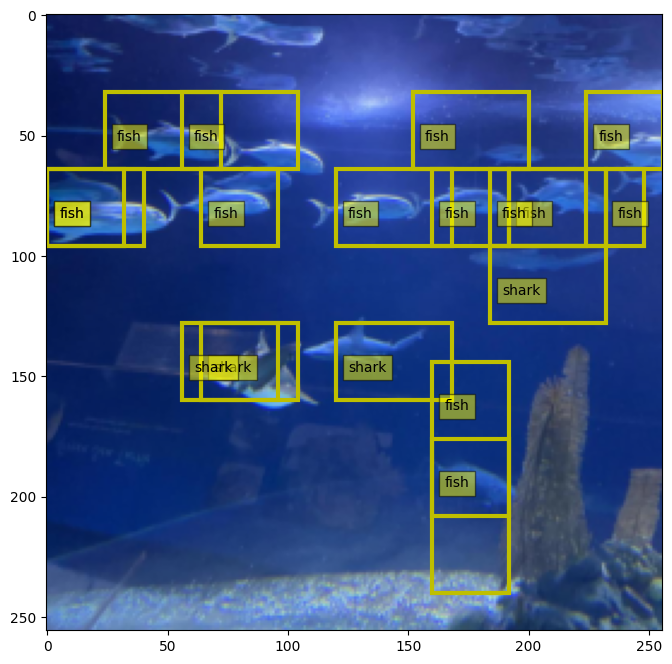

In [ ]:
nrows, ncols = (1, 1)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch[1], fig, axes)
fig, _ = display_bbox(positive_anc_coords[1], fig, axes, classes=gt_classes[1])


## Building the model

In [50]:
# ------------------- Loss Utils ----------------------

def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)

    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))

    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size

    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

In [ ]:
from itertools import filterfalse
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = get_backbone_model(requires_grad=True)

    def forward(self, img_data):
        return self.backbone(img_data)

class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):

        super().__init__()
        self.in_features = in_features
        self.hidden_dim = hidden_dim
        self.n_anchors = n_anchors
        self.p_dropout = p_dropout

        self.conv = nn.Conv2d(self.in_features, self.hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(self.p_dropout)
        self.conf_head = nn.Conv2d(self.hidden_dim, self.n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(self.hidden_dim, 4*self.n_anchors, kernel_size=1)


    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        train = False

        if pos_anc_ind != None and neg_anc_ind != None and pos_anc_coords != None:
            # if any of these is None then the mode is eval otherwise its train
            train = True

        out = self.conv(feature_map)
        out = F.relu(self.dropout(out))

        reg_offsets = self.reg_head(out)
        conf_scores = self.conf_head(out)

        if train:
            conf_scores_pos = conf_scores.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores.flatten()[neg_anc_ind]

            offsets_pos = reg_offsets.contiguous().view(-1, 4)[pos_anc_ind]
            proposals = generate_proposals(pos_anc_coords, offsets_pos)

            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals

        else:
            return conf_scores, reg_offsets

In [ ]:
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()
        self.out_channels = out_channels
        self.n_classes = n_classes
        self.roi_size = roi_size
        self.hidden_dim = hidden_dim
        self.p_dropout = p_dropout

        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(self.out_channels, self.hidden_dim)
        self.dropout = nn.Dropout(self.p_dropout)

        self.cls = nn.Linear(hidden_dim, n_classes)

    def forward(self, feature_map, proposals_list, gt_classes=None):

        train = False
        if gt_classes != None:
            train = True

        # 1. Apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        # 2. Flatten the output
        roi_out = roi_out.squeeze(-1).squeez(-1)
        # 3. Pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        # 4. Get the classification scores
        cls_scores = self.cls(out)
        # 5. Compute cross entropy loss
        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())

        return cls_loss


In [ ]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):

        super().__init__()

        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size

        # 1. Downsampling scale factor
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h

        # 2. Define scales and ratios for anchor boxes
        anchor_scales = [32, 64, 96] / 32 # since its feature map
        anchor_ratios = [0.5, 1.0, 1.5]

        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)

        # 3. Define thresholds for positive and negative anchors
        self.pos_thresh = 0.5
        self.neg_thresh = 0.3

        # 4. Define weights for loss (as the loss function is a combination of two terms)
        self.w_conf = 1
        self.w_reg = 5

        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)


    def forward(self, images, gt_bboxes, gt_classes):

        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)

        # 1. Generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        # 2. Get positive and negative anchors amongst other things
        positive_anc_indices, positive_anc_coords, negative_anc_indices, negative_and_coords, gt_conf_scores, gt_offsets, gt_classes, positive_anc_ind_sep = get_req_anchors(anchor_boxes, gt_bboxes, gt_classes)
        # 3. Pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_indices, negative_anc_indices, positive_anc_coords)

        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(gt_offsets, offsets_pos, batch_size)
        # 4. define the loss as, weight_cls * cls_loss + weight_reg * reg_loss
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss

        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, gt_classes

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):

        with torch.no_grad():


            batch_size = images.size(dim=0)
            feature_map = self.feature_extractor(images)

            # 1. Generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # 2. Get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # 3. Filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # 4.1. Filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # 4.2. Filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)

        return proposals_final, conf_scores_final, feature_map


In [ ]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__()
        # first stage: RPN
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        # second stage: classification
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)


    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, gt_class_pos = self.rpn(images, gt_bboxes, gt_classes)

        pos_proposals_list = []
        batch_size = images.size(dim=0)
        # 1. Get separate proposals for each sample
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)

        # 2. Calculate the final loss as cls_loss + total_rpn_loss
        cls_loss = self.classifier(feature_map, pos_proposals_list, gt_class_pos)
        total_loss = cls_loss + total_rpn_loss

        return total_loss

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):

        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)

        # 1. Convert the scores you get from the classifier into probability
        cls_probs = F.softmax(cls_scores, dim=-1)

        # 2. Get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)

        classes_final = []
        # 3. Slice classes to map to their corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals

        return proposals_final, conf_scores_final, classes_final
